# Analyzing the Output of a Network

In the previous tutorial, I showed how to train a network with minibatching, batch norm, and writing to file to save the network weights.  Here, I'll show you how to restore that network to do analysis.  The network model itself is copy/pasted from the previous tutorial, though there are ways to load the network without knowing how it was constructed.

In [1]:
import os
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
from matplotlib import pyplot as plt
import numpy
%matplotlib inline

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Set up the convolutional network, copied from before:

In [2]:
def convolutional_step(x, training):
    
    n_filters = 2*x.get_shape().as_list()[-1]
 

    x = tf.layers.conv2d(x, filters=n_filters,
                        kernel_size=[3,3],
                        strides=[1,1],
                        padding='same',
                        use_bias=False,
                        reuse=False,
                        trainable=training)
    

    # Here's an important gotcha: I set the decay to 0.9, and updates_collection to None
    # This forces the update to happen "in place" and makes sure the batch norm parameters
    # Get saved to files.
    x = tf.contrib.layers.batch_norm(x,
                                     updates_collections=None,
                                     decay=0.9,
                                     is_training=training,
                                     trainable=training,
                                     # name="BatchNorm",
                                     reuse=False)
    x = tf.nn.relu(x)
    return x

def build_network(x, training):
    
    print("Building network, initial shape: {0}".format(x.get_shape()))
        
    # Initial convolutions:
    x = convolutional_step(x, training)
    x = convolutional_step(x, training)
    
    # Downsample to 14x14:
    x = tf.layers.max_pooling2d(x,
                                 pool_size=2,
                                 strides=2,
                                 padding='valid')
    
    print("After first downsample shape: {0}".format(x.get_shape()))
    
    # More convolutions:
    x = convolutional_step(x, training)
    x = convolutional_step(x, training)
    
    # Downsample to 7x7:
    x = tf.layers.max_pooling2d(x,
                                 pool_size=2,
                                 strides=2,
                                 padding='valid')
    
    print("After first downsample shape: {0}".format(x.get_shape()))
    
    # More convolutions:
    x = convolutional_step(x, training)
    x = convolutional_step(x, training)
    
    # Downsample to 3x3:
    x = tf.layers.max_pooling2d(x,
                                 pool_size=2,
                                 strides=2,
                                 padding='valid')
    
    print("After last downsample shape: {0}".format(x.get_shape()))
    
    # Do a bottle neck step to merge into just 10 filters:
    
    x = tf.layers.conv2d(x,filters=10,
                        kernel_size=[1,1],
                        strides=[1,1],
                        padding='same',
                        use_bias=False,
                        reuse=False,
                        trainable=training
                        )
    
    
    # Do global average pooling to make 10 output logits:
    shape = (x.shape[1], x.shape[2])

    x = tf.nn.pool(x,
                   window_shape=shape,
                   pooling_type="AVG",
                   padding="VALID",
                   dilation_rate=None,
                   strides=None,
                   name="GlobalAveragePool",
                   data_format=None)

    # Reshape to remove empty dimensions:
    x = tf.reshape(x, [tf.shape(x)[0], 10],
                   name="global_pooling_reshape")

    
    return x

Also set up the placeholders:

In [3]:
tf.reset_default_graph()
# Define the input placeholders, as defined in the tensorflow mnist tutorial:
x  = tf.placeholder(tf.float32, shape=[None, 784], name='x')
y_ = tf.placeholder(tf.float32, shape=[None, 10], name='y_')

reshaped_x = tf.reshape(x, [-1, 28, 28, 1])

y = build_network(reshaped_x, training=True)
print "Final output shape: {0}".format(y.get_shape())

Building network, initial shape: (?, 28, 28, 1)
After first downsample shape: (?, 14, 14, 4)
After first downsample shape: (?, 7, 7, 16)
After last downsample shape: (?, 3, 3, 64)
Final output shape: (?, 10)


In [4]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


Restore the network using a saver.  If you point it to the write folder, tensorflow keeps track of what the most recent weights file is:

In [8]:
writer = tf.train.Saver()
save_dir     = '/home/cadams/DeepLearnPhysics/mnist-train-and-analyze' + "/log_mnist_classifier/checkpoints"
latest_checkpoint = tf.train.latest_checkpoint(save_dir)
print ("Latest Checkpoint is: {0}".format(latest_checkpoint))

Latest Checkpoint is: /home/cadams/DeepLearnPhysics/mnist-train-and-analyze/log_mnist_classifier/checkpoints/save-1000


In [9]:
sess = tf.Session()
writer.restore(sess, latest_checkpoint)

INFO:tensorflow:Restoring parameters from /home/cadams/DeepLearnPhysics/mnist-train-and-analyze/log_mnist_classifier/checkpoints/save-1000


At this point, we're ready to go.  Let's loop through the validation data set and get the predictions for each class:

In [12]:
images = mnist.validation.images
labels = mnist.validation.labels

How many are we looking at?  It's possible they can all be processed at once, but I'll do it in batches.

In [13]:
print "Images.shape: {0}".format(images.shape)

Images.shape: (5000, 784)


In total, 5000 images. Let's do 50 batches of 100 images:

In [15]:
predicted_labels = numpy.zeros((5000,10))
for batch in range(50):
    batch_images = images[batch*100:(batch+1)*100]
    batch_labels = labels[batch*100:(batch+1)*100]
    batch_predictions = sess.run(y, feed_dict={x:batch_images, y_:batch_labels})
    predicted_labels[batch*100:(batch+1)*100] = batch_predictions

Let's look at some predictions:

In [16]:
print "True Label: {0}".format(labels[0])
print "Prediction: {0}".format(predicted_labels[0])

True Label: [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
Prediction: [-3.77722335 -4.80439615 -1.45840096  4.89647245 -5.67046452  7.00556707
 -2.71908355 -4.13560677  2.23484254 -3.28994966]


Looks funky, right?  It's because the softmax function is only applied at the loss calculation, so we need to apply it ourselves here.  It's easy to do with numpy:

In [29]:
_exp = numpy.exp(predicted_labels)
_sum = numpy.expand_dims(numpy.sum(_exp, axis=1), axis=1)
print _sum.shape
softmax_labels = _exp / _sum

(5000, 1)


In [30]:
print softmax_labels[0]

[  1.83632246e-05   6.57435975e-06   1.86638275e-04   1.07371043e-01
   2.76518857e-06   8.84820804e-01   5.29045741e-05   1.28323148e-05
   7.49818213e-03   2.98929807e-05]


This looks much more reasonable.  It claims an 88% probability that the label is the 5th index, just like the truth.  Let's find the predicted label for all entries:

In [36]:
classified_index = numpy.argmax(softmax_labels, axis=1) 
true_index       = numpy.argmax(labels, axis=1) 

We can quickly compute the accuracy:

In [37]:
print "Accuracy on validation data: {0}".format(
    numpy.mean(classified_index==true_index))

Accuracy on validation data: 0.9834


That's good accuracy, on par with the training and testing sets.  Let's generate a matrix to show it's classification results as a function of input label.

In [46]:
confusion_matrix = numpy.zeros((10,10))
for true_label in range(10):
    indexes = numpy.where(true_index == true_label)
    count = len(indexes[0])
    for predicted_label in range(10):
        this_category_count = numpy.sum(classified_index[indexes] == predicted_label)
        confusion_matrix[true_label,predicted_label] = 1.0*this_category_count/count

Now, let's display the confusion matrix:

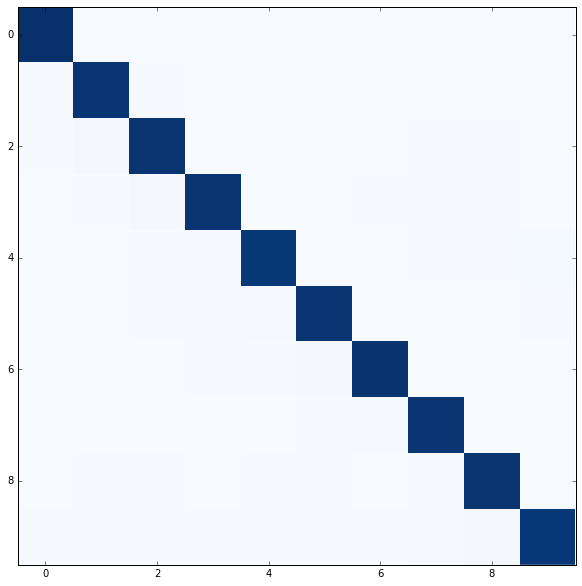

In [58]:
from matplotlib import colors
figure = plt.figure(figsize=(10,10))
plt.imshow(confusion_matrix,vmin=0,vmax=1.0, cmap='Blues', interpolation='none',)

I know there are entries off the diagonal, but they're pretty small.  You can play around with the color map to highlight these, but the results look pretty good!